In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Data Processing

In [3]:
import json

# Load the dataset from the GitHub JSON file
with open('/content/drive/MyDrive/Model/github_data.json', 'r') as f:
    github_data = json.load(f)

# Load the dataset from the OpenAI API JSON file
with open('/content/drive/MyDrive/Model/openai_api_data.json', 'r') as f:
    openai_api_data = json.load(f)

# Extract prompts and answers from both datasets
prompts = [item['Prompt'] for item in github_data]

# Assuming both JSON files have responses in the same order as prompts
github_answers = [item['Answer'] for item in github_data]
openai_api_answers = [item['Answer'] for item in openai_api_data]


### Text Similarity (Cosine Similarity)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
github_answers_vectorized = vectorizer.fit_transform(github_answers)
openai_api_answers_vectorized = vectorizer.transform(openai_api_answers)

# Calculate cosine similarity
similarity_scores = cosine_similarity(github_answers_vectorized, openai_api_answers_vectorized)


### Model Training (Logistic Regression)

In [14]:
from sklearn.model_selection import GridSearchCV

# Assuming similarity_scores is a 2D array with shape (num_prompts, num_responses)
similarity_scores = cosine_similarity(github_answers_vectorized, openai_api_answers_vectorized)

# Flatten similarity scores to a 1D array
flattened_scores = similarity_scores.flatten()

# Create labels (1 for similar, 0 for not similar)
labels = [1] * (len(flattened_scores) // 2) + [0] * (len(flattened_scores) - len(flattened_scores) // 2)

# Reshape the data for compatibility with scikit-learn
X = flattened_scores.reshape(-1, 1)

# Make sure the length of labels matches the number of samples in X
y = labels[:len(flattened_scores)]

# Create a logistic regression model
base_model = LogisticRegression()

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'max_iter': [100, 500, 1000],  # Maximum number of iterations
}

# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

# Rest of the code remains the same


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000]},
             scoring='f1')

### Evaluation

Accuracy: 0.5201151426053501
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.58      0.55    251341
           1       0.52      0.46      0.49    251340

    accuracy                           0.52    502681
   macro avg       0.52      0.52      0.52    502681
weighted avg       0.52      0.52      0.52    502681



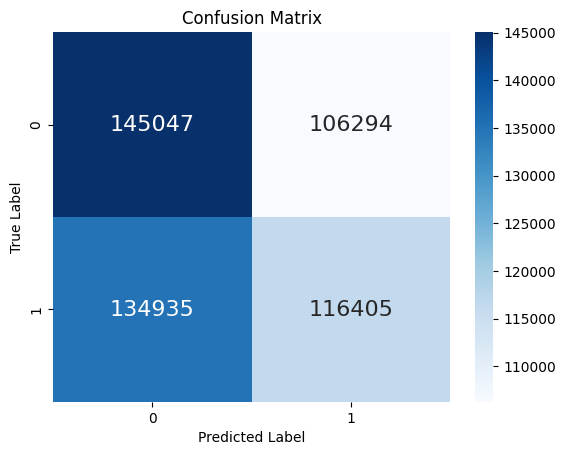

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the same set
y_pred = model.predict(X)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
